In [1]:
from typing import List, Tuple
import pickle as pic
from collections import Counter

import numpy as np
#import cupy as np
import matplotlib.pyplot as plt
import scipy.io as sio

In [2]:
import log_parser

In [3]:
KEYROUND_WIDTH_4 = 60
KEYROUND_WIDTH_B4 = 98

KEY_WIDTH_4 = 256
KEY_WIDTH_B4 = 512

BLOCK_WIDTH_4 = 5
BLOCK_WIDTH_B4 = 7

In [4]:
HW = [bin(n).count("1") for n in range(0, 256)]

In [23]:
def corr_coef(hypotheses, traces):
    #Initialize arrays & variables to zero
    num_traces, num_points = traces.shape
    sumnum = np.zeros(num_points)
    sumden1 = np.zeros(num_points)
    sumden2 = np.zeros(num_points)

    #Mean of hypotheses
    h_mean = np.mean(hypotheses, dtype=np.float64)

    #Mean of all points in trace
    t_mean = np.mean(traces, axis=0, dtype=np.float64)

    #For each trace, do the following
    for t_idx in range(num_traces):
        h_diff = (hypotheses[t_idx] - h_mean)
        t_diff = traces[t_idx, :] - t_mean

        sumnum = sumnum + (h_diff * t_diff)
        sumden1 = sumden1 + h_diff * h_diff 
        sumden2 = sumden2 + t_diff * t_diff

    correlation = sumnum / np.sqrt(sumden1 * sumden2)

    return correlation

In [24]:
def corr_coef_vectorized(hypotheses, traces):
    h_mean = np.mean(hypotheses)
    t_mean = np.mean(traces, axis=0)
    h_diff, t_diff = hypotheses - h_mean, traces - t_mean

    r_num = np.sum(h_diff[:, None] * t_diff, axis=0)
    r_den = np.sqrt(np.sum(h_diff * h_diff, axis=0) * np.sum(t_diff * t_diff, axis=0))
    r = r_num / r_den
    r = np.clip(r, -1.0, 1.0)
    return r

# Elisabeth-b4 - Filter block

## Attacking S-box S1

In [99]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.log"

In [100]:
traces_dict = sio.loadmat(traces_path)

traces = np.empty((len([k for k in traces_dict.keys() if 'data' in k]), 60000))
for i, k in enumerate([k for k in traces_dict.keys() if 'data' in k]):
    traces[i] = traces_dict[k][0, 0][4][:, 0]

num_traces = np.shape(traces)[0]
num_points = np.shape(traces)[1]

In [101]:
real_keys = log_parser.parse(key_path)

real_keys = np.array([key[0][0] for key in real_keys])

### Check our data

In [106]:
NR_PLOT = 5

C:\Users\ppace\AppData\Local\Temp\ipykernel_12796\3963726462.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


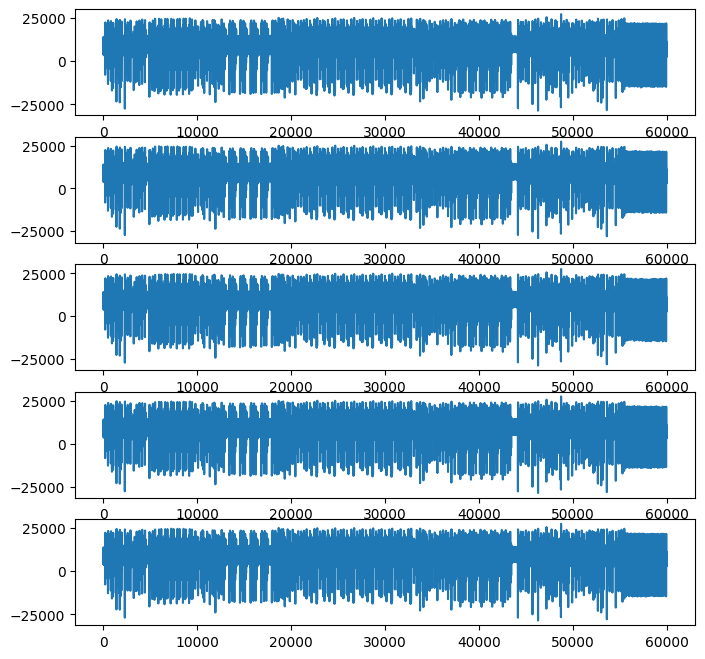

In [107]:
fig, axs = plt.subplots(NR_PLOT, figsize=(8, 8))
for ax, trace in zip(axs, traces[:NR_PLOT]):
    ax.plot(trace)
fig.show()

### Find the timepoint where S1 is executed

In [12]:
s1 = [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A]

def hypothesis_s1(x1: int, x2: int) -> int:
    return HW[s1[(x1 + x2) % 16]]


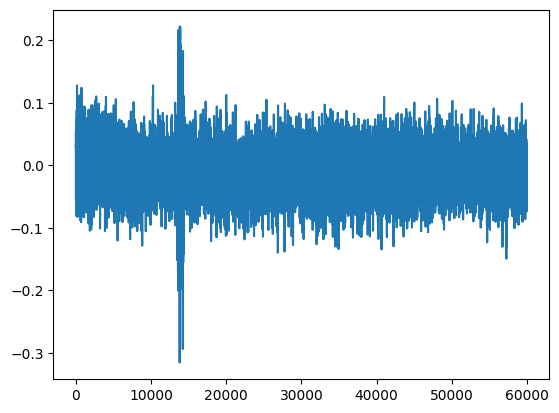

In [13]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))

Wow !!!

(13500.0, 14500.0)

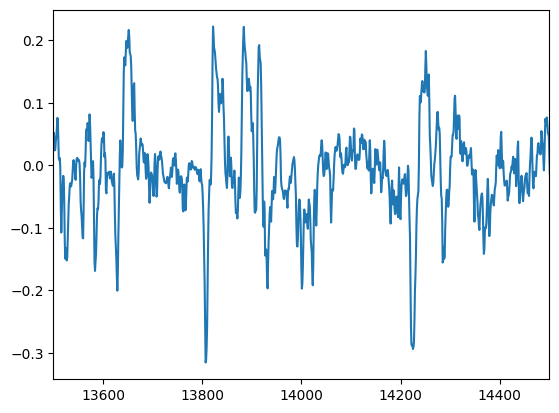

In [14]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))
plt.xlim([13500, 14500])

## Attacking the filter S-boxes

### Finding their locations in time

In [7]:
s_boxes_b4 = [
    [0x0A, 0x06, 0x0B, 0x08, 0x04, 0x09, 0x08, 0x0C, 0x06, 0x0A, 0x05, 0x08, 0x0C, 0x07, 0x08, 0x04],
    [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A],
    [0x0D, 0x0E, 0x0E, 0x02, 0x03, 0x09, 0x03, 0x05, 0x03, 0x02, 0x02, 0x0E, 0x0D, 0x07, 0x0D, 0x0B],
    [0x02, 0x09, 0x08, 0x0B, 0x0D, 0x08, 0x01, 0x07, 0x0E, 0x07, 0x08, 0x05, 0x03, 0x08, 0x0F, 0x09],
    [0x0B, 0x03, 0x0F, 0x09, 0x00, 0x00, 0x0C, 0x00, 0x05, 0x0D, 0x01, 0x07, 0x10, 0x10, 0x04, 0x10],
    [0x0F, 0x0C, 0x01, 0x0F, 0x0E, 0x01, 0x06, 0x0C, 0x01, 0x04, 0x0F, 0x01, 0x02, 0x0F, 0x0A, 0x04],
    [0x06, 0x0E, 0x0D, 0x00, 0x07, 0x0E, 0x0C, 0x03, 0x0A, 0x02, 0x03, 0x10, 0x09, 0x02, 0x04, 0x0D],
    [0x0C, 0x00, 0x04, 0x01, 0x0F, 0x0B, 0x04, 0x00, 0x04, 0x10, 0x0C, 0x0F, 0x01, 0x05, 0x0C, 0x10],
    [0x0B, 0x00, 0x0F, 0x0A, 0x09, 0x0B, 0x09, 0x02, 0x05, 0x10, 0x01, 0x06, 0x07, 0x05, 0x07, 0x0E],
    [0x0D, 0x03, 0x0B, 0x0B, 0x08, 0x09, 0x08, 0x0C, 0x03, 0x0D, 0x05, 0x05, 0x08, 0x07, 0x08, 0x04],
    [0x0A, 0x02, 0x08, 0x04, 0x0F, 0x0B, 0x06, 0x04, 0x06, 0x0E, 0x08, 0x0C, 0x01, 0x05, 0x0A, 0x0C],
    [0x0D, 0x08, 0x0E, 0x08, 0x02, 0x05, 0x03, 0x0B, 0x03, 0x08, 0x02, 0x08, 0x0E, 0x0B, 0x0D, 0x05],
    [0x0D, 0x0F, 0x02, 0x05, 0x05, 0x0F, 0x09, 0x0B, 0x03, 0x01, 0x0E, 0x0B, 0x0B, 0x01, 0x07, 0x05],
    [0x0D, 0x00, 0x0A, 0x0A, 0x06, 0x07, 0x03, 0x0E, 0x03, 0x10, 0x06, 0x06, 0x0A, 0x09, 0x0D, 0x02],
    [0x00, 0x04, 0x07, 0x00, 0x09, 0x04, 0x0C, 0x00, 0x10, 0x0C, 0x09, 0x10, 0x07, 0x0C, 0x04, 0x10],
    [0x04, 0x0B, 0x06, 0x03, 0x0F, 0x06, 0x0C, 0x02, 0x0C, 0x05, 0x0A, 0x0D, 0x01, 0x0A, 0x04, 0x0E],
    [0x03, 0x0C, 0x01, 0x08, 0x08, 0x0F, 0x0D, 0x0F, 0x0D, 0x04, 0x0F, 0x08, 0x08, 0x01, 0x03, 0x01],
    [0x0B, 0x03, 0x02, 0x0C, 0x03, 0x08, 0x04, 0x02, 0x05, 0x0D, 0x0E, 0x04, 0x0D, 0x08, 0x0C, 0x0E]
]

In [8]:
from ctypes import *

class aes_ctx(Structure):
    _fields_ = [
        ("RoundKey", c_uint8 * 176),
        ("Iv", c_uint8 * 16)
    ]

class ecrypt_ctx(Structure):
    _fields_ = [
        ("input", c_uint32 * 16)
    ]

class rng(Structure):
    pass

rng._fields_ = [
    ("indices", c_uint16 * 512),
    ("whitening", c_uint8 * 98),
    ("mode", c_int),
    ("gen_rand_uniform", CFUNCTYPE(c_uint8, POINTER(rng), POINTER(c_uint8))),
    ("copy", CFUNCTYPE(None, POINTER(rng), POINTER(rng))),
    ("next_elem", CFUNCTYPE(None, POINTER(rng)))
]

class rng_aes(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", aes_ctx),
        ("ctr", c_uint8 * 16),
        ("batch_idx", c_size_t)
    ]

class rng_cha(Structure):
    _fields_ = [
        ("r", rng),
        ("ctx", ecrypt_ctx),
        ("batch_idx", c_size_t)
    ]

lib = CDLL("./py_gen_rng.so")

def aes_random_4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def aes_random_b4(seed: str):
    r = rng_aes()
    lib.rng_new_aes(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 1)
    return list(r.r.indices), list(r.r.whitening)
    
def chacha_random_b4(seed: str):
    r = rng_cha()
    lib.rng_new_cha(byref(r), int(seed, 16).to_bytes(length=16, byteorder="little"), 0)
    return list(r.r.indices), list(r.r.whitening)

In [9]:
def hypothesis_b4_rws_sboxes_location(iv: str, key: List[int], round_idx: int, block_idx: int) -> int:
    indices, whitening = chacha_random_b4(iv)

    block = [(key[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

    if block_idx != BLOCK_WIDTH_B4 - 1:
        if block_idx % 2 == 0:
            sbox_out = s_boxes_b4[block_idx][block[block_idx]]
        else:
            sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
        return HW[sbox_out]
    else:
        for i in range(3):
            block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
        y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
        z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
        z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
        t_0 = (z[0] + z[1] + z[2]) % 16
        t_0 = (t_0 + block[block_idx - 1]) % 16
        sbox_out = s_boxes_b4[12][t_0]

        return HW[(block[block_idx] + sbox_out) % 16]

In [10]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-3-WhiteningAndFullFilter-1_key_256000_samples\\carto_eB4-Rnd-3-WhiteningAndFullFilter.log"

In [12]:
traces_dict = sio.loadmat(traces_path)
traces_size = Counter([traces_dict[k][0, 0][4][:, 0].shape[0] for k in traces_dict.keys() if k.startswith("data_")]).most_common(1)[0][0]
empty_traces = {k for k in traces_dict.keys() if k.startswith("data_") and traces_dict[k][0, 0][4][:, 0].shape[0] != traces_size}
traces = np.stack([traces_dict[k][0, 0][4][:, 0] for k in traces_dict.keys() if k.startswith("data_") and k not in empty_traces], axis=0)
traces = traces.reshape((1, -1, traces.shape[1]))
traces.shape

(1, 255983, 50002)

In [13]:
inputs_outputs = log_parser.parse(key_path)
real_keys = np.array([inputs_outputs[1][0][0]])
real_keys = np.array([[int(c, 16) for c in key] for key in real_keys])

seeds = np.array([inputs_outputs[2 * (int(k[len("data_"):]) - 1)][0][0] for k in traces_dict.keys() if k.startswith("data_") and k not in empty_traces])
seeds = seeds.reshape((-1, traces.shape[1]))

del traces_dict

In [14]:
assert traces.shape[0] == seeds.shape[0]

In [17]:
with open("correlation_locations_b4_two_last_rounds.pic", "rb") as r:
    correlation_locations = pic.load(r)

In [15]:
correlation_locations = [[[0] * 10] * BLOCK_WIDTH_B4] * (KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2)

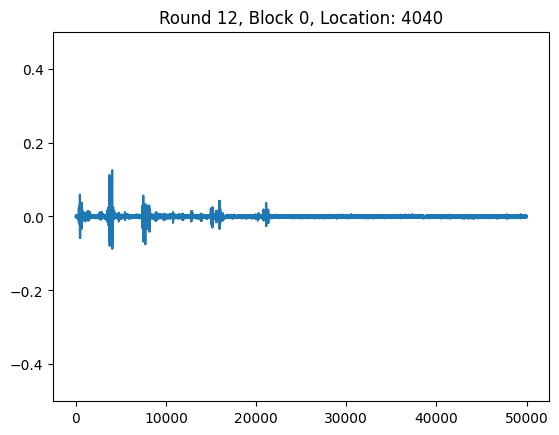

KeyboardInterrupt: 

In [16]:
for round_idx in range(len(correlation_locations), KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4):
    corr_round = []
    for block_idx in range(BLOCK_WIDTH_B4):
        hyps = np.array([hypothesis_b4_rws_sboxes_location(iv, key, round_idx, block_idx) for i, key in enumerate(real_keys) for iv in seeds[i]])
        corr = corr_coef_naive(hyps, traces.reshape((-1, traces.shape[2])))
        loc = np.argmax(corr)
        corr_round.append(list(range(loc - 5, loc + 5)))
        plt.plot(corr)
        plt.ylim([-0.5, 0.5])
        plt.title(f"Round {round_idx}, Block {block_idx}, Location: {loc}")
        plt.show()
    correlation_locations.append(corr_round)
correlation_locations = np.array(correlation_locations)

In [50]:
with open("correlation_locations_b4_two_last_rounds.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [36]:
with open("correlation_locations_b4_1000.pic", "wb") as w:
    pic.dump(correlation_locations, w)

In [22]:
def indices_locations_and_hyps_to_use_for_key_nibble(key_guess: List[int], key_target_idx: int, total_seeds: np.ndarray, total_traces: np.ndarray, locations: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    seeds_indices = np.zeros_like(total_seeds, dtype=bool)
    location_mask_per_trace = np.zeros_like(total_traces, dtype=bool)
    hypotheses = np.zeros_like(total_seeds, dtype=int)

    for i, iv in enumerate(total_seeds):
        indices, whitening = chacha_random_b4(iv)
        keyround_target_idx = indices.index(key_target_idx)
        if keyround_target_idx < KEYROUND_WIDTH_B4:
            round_idx = keyround_target_idx // BLOCK_WIDTH_B4
            block_idx = keyround_target_idx % BLOCK_WIDTH_B4
            locs = locations[round_idx][block_idx]

            # For now, we only attack even-indexed keyrounds (but not the last one) because they depend on a single key nibble
            # TO REMOVE IF BETTER IDEA IS FOUND
            #if block_idx == BLOCK_WIDTH_B4 - 1 or block_idx % 2 != 0:
            if round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 or block_idx != 4:
            #if (round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 1 and round_idx != KEYROUND_WIDTH_B4 // BLOCK_WIDTH_B4 - 2) or block_idx != 0:
                continue
            # TO REMOVE IF BETTER IDEA IS FOUND

            seeds_indices[i] = True
            location_mask_per_trace[i][locs] = True

            block = [(key_guess[indices[i]] + whitening[i]) % 16 for i in range(BLOCK_WIDTH_B4 * round_idx, BLOCK_WIDTH_B4 * (round_idx + 1))]

            if block_idx != BLOCK_WIDTH_B4 - 1:
                if block_idx % 2 == 0:
                    sbox_out = s_boxes_b4[block_idx][block[block_idx]]
                else:
                    raise ValueError("Should not happen")
                    sbox_out = s_boxes_b4[block_idx][(block[block_idx] + block[block_idx - 1]) % 16]
                hypotheses[i] = HW[sbox_out]
            else:
                raise ValueError("Should not happen")
                for i in range(3):
                    block[2*i + 1] = (block[2*i + 1] + block[2*i]) % 16
                y = [s_boxes_b4[i][block[i]] for i in range(BLOCK_WIDTH_B4 - 1)]
                z = [(y[(2*i + 5*j - 1) % (BLOCK_WIDTH_B4 - 1)] + y[2*i + j]) % 16 for i in range(3) for j in range(2)]
                z = [s_boxes_b4[6 + i][(z[i] + block[(i + 2) % (BLOCK_WIDTH_B4 - 1)]) % 16] for i in range(BLOCK_WIDTH_B4 - 1)]
                t_0 = (z[0] + z[1] + z[2]) % 16
                t_0 = (t_0 + block[block_idx - 1]) % 16
                sbox_out = s_boxes_b4[12][t_0]

                hypotheses[i] = HW[(block[block_idx] + sbox_out) % 16]

    return seeds_indices, location_mask_per_trace, hypotheses[seeds_indices]

Key 0: 

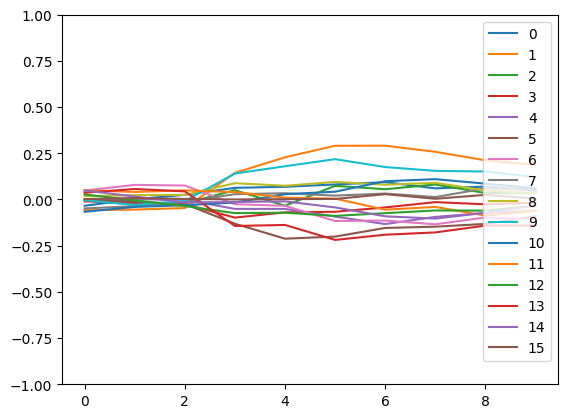

1[ 0.09368982  0.29111366  0.08120962 -0.01015914  0.00147026 -0.00086094
  0.07908085  0.06034278  0.09504207  0.21813562  0.10990965  0.04970929
  0.02709318  0.05684756  0.04885629  0.02880857]


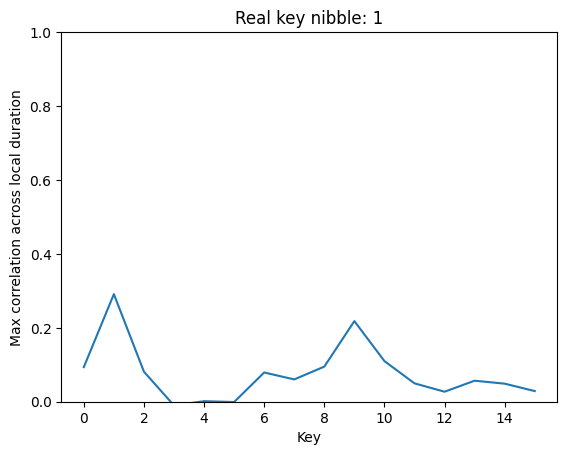

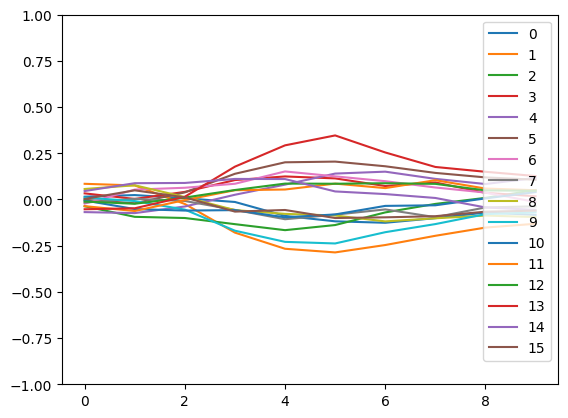

D[0.02385939 0.08477846 0.05081246 0.12467709 0.15049943 0.20497118
 0.15172408 0.00347745 0.0768483  0.01027294 0.03996036 0.10421561
 0.08796937 0.34656432 0.11116277 0.04949018]


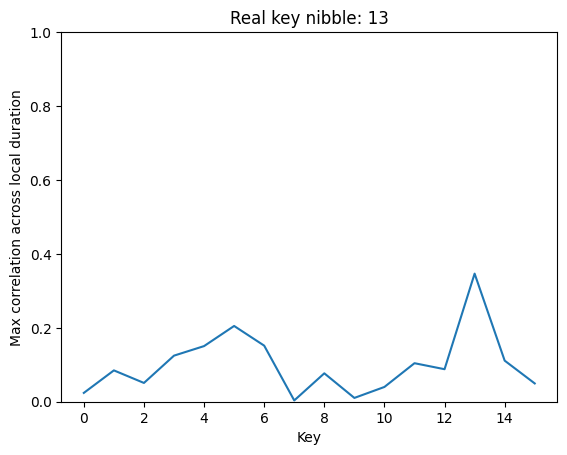

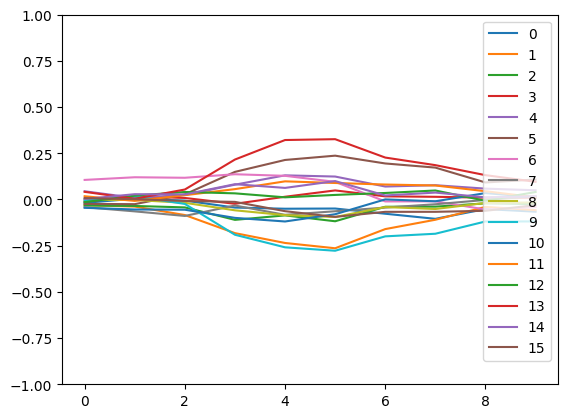

D[ 0.00423076 -0.03066843 -0.02088909  0.04900725  0.13062626  0.23704849
  0.13652834  0.0187979  -0.00132093  0.01749272  0.03459829  0.09816
  0.04859985  0.3262518   0.0995372   0.00767213]


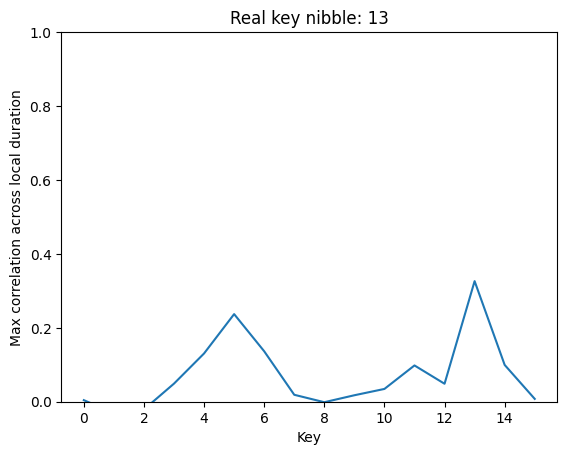

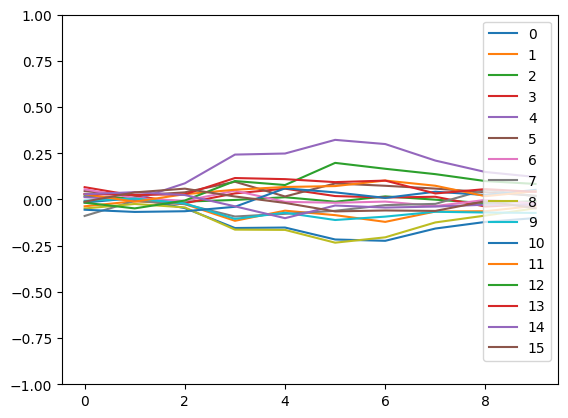

4[ 0.00729125 -0.00944872  0.01748116  0.06663659  0.32257668  0.09592102
  0.05526864  0.05295618 -0.02418526  0.0050497   0.06015293  0.10248262
  0.19803463  0.11605479  0.03966525  0.0585427 ]


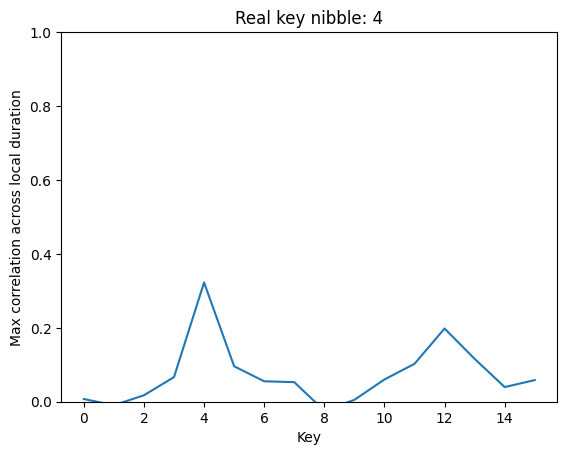

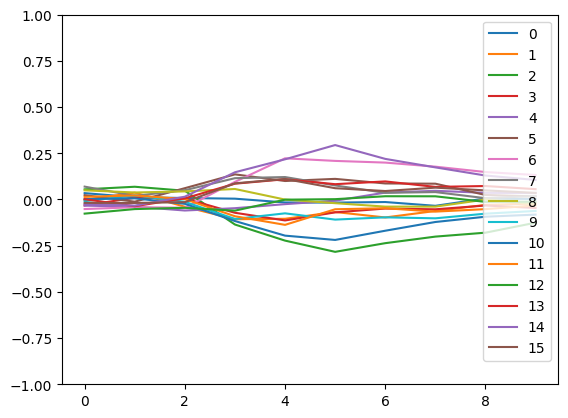

E[0.03433336 0.03705327 0.06888114 0.00910957 0.0469228  0.13591191
 0.22272856 0.12138624 0.05676831 0.02237484 0.00617403 0.02202801
 0.01751523 0.109368   0.29447687 0.11102425]


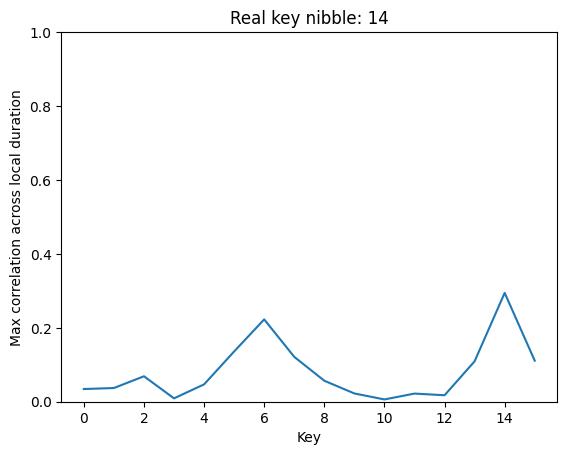

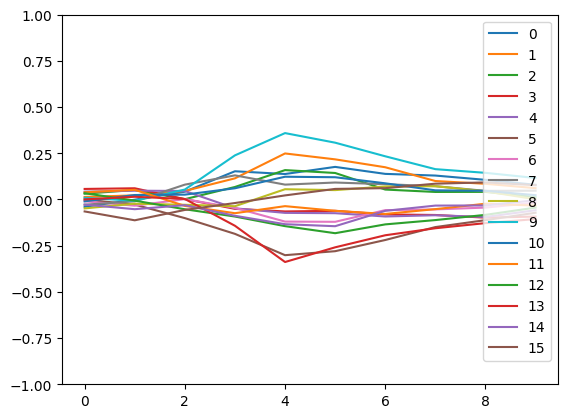

9[ 1.76313920e-01  2.49024260e-01  1.58973559e-01  6.06138672e-02
  4.75094551e-02 -3.28539218e-04  1.92652639e-03  1.30497537e-01
  7.18695939e-02  3.59230643e-01  1.23105264e-01  5.22787951e-02
  3.39465506e-02  1.46936967e-02 -4.06894923e-03  9.23961374e-02]


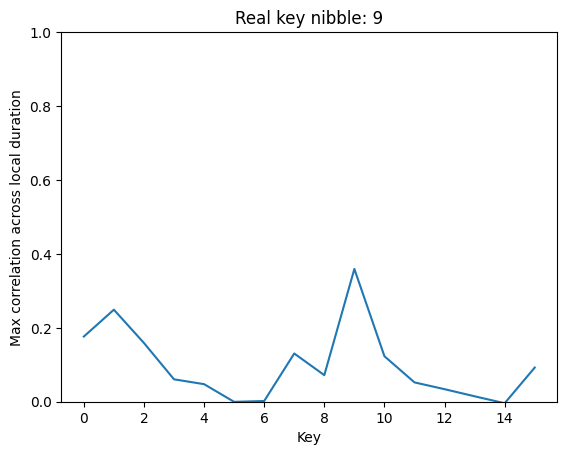

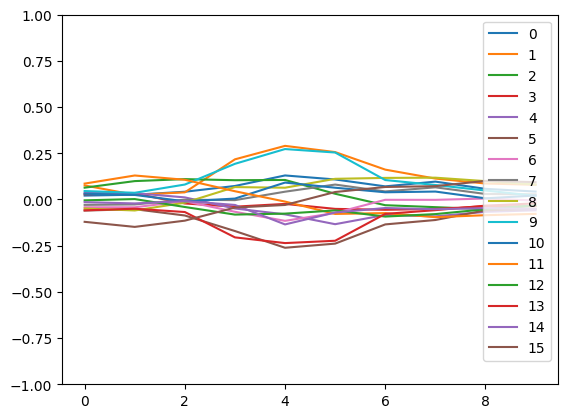

1[ 0.1300379   0.29011231  0.11013493  0.03247869  0.03576963 -0.05076512
  0.00508573  0.08068941  0.11796033  0.2728331   0.09145425  0.12979138
  0.00220349 -0.02117032 -0.00852253  0.10058086]


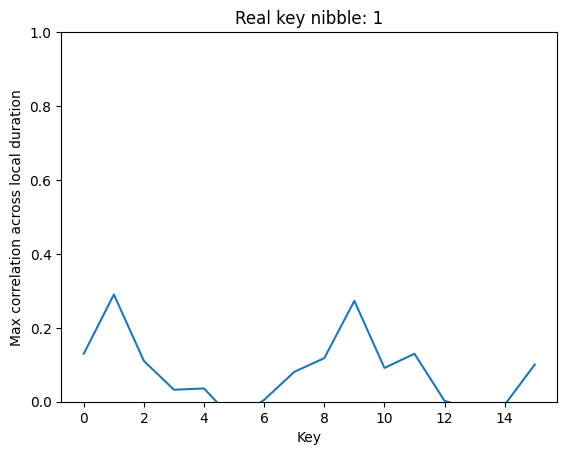

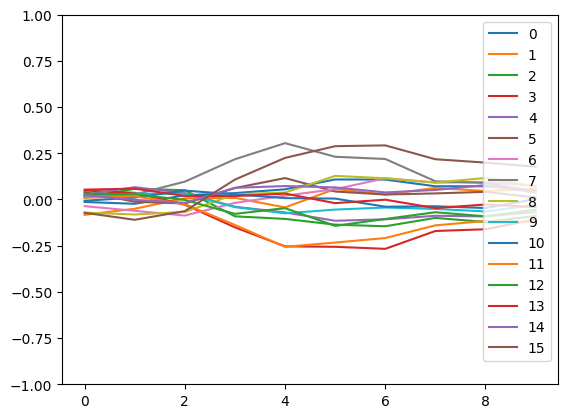

7[0.10831087 0.06255211 0.05779852 0.04831825 0.06643942 0.11583842
 0.11475258 0.30477014 0.1277174  0.03170142 0.04795622 0.01712766
 0.03161991 0.05866658 0.07794245 0.29276046]


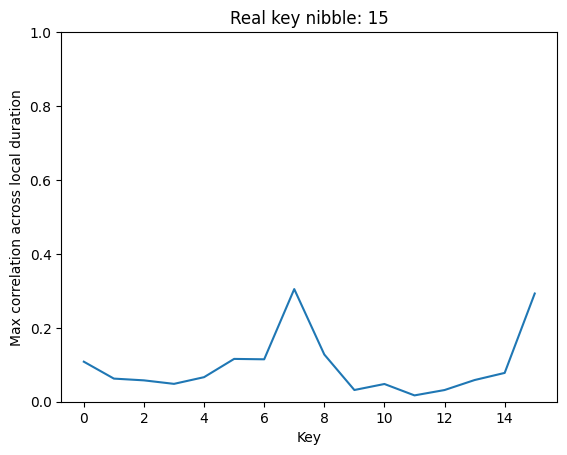

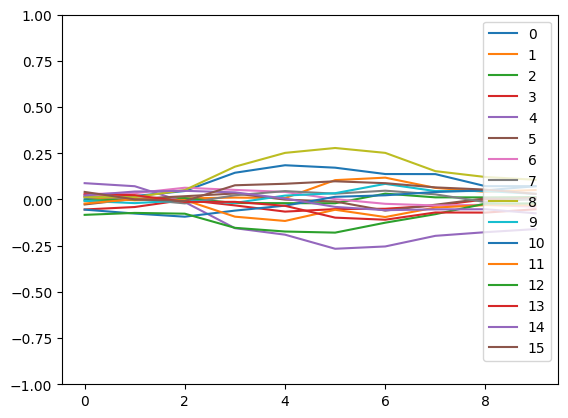

8[ 0.18523556  0.11812735  0.03156714  0.00662893  0.08826139  0.03240524
  0.06349583  0.04761534  0.27861168  0.08447681  0.0717624   0.00141689
 -0.02146324  0.02814207  0.04682916  0.09834947]


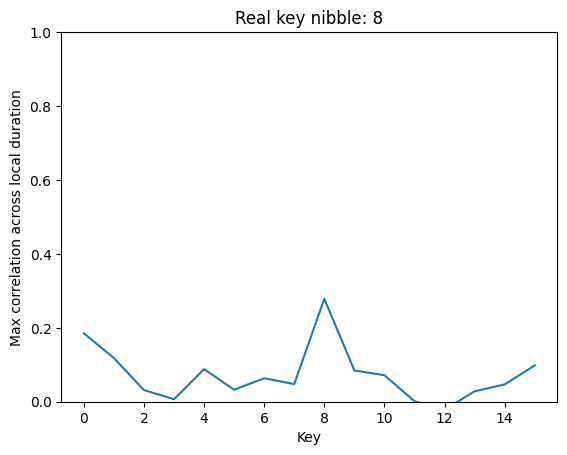

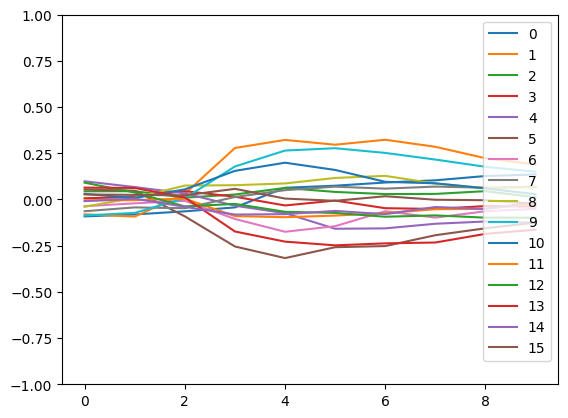

1[ 0.13500606  0.3231648   0.06249873  0.04503774  0.09838027  0.0541515
 -0.007384    0.06981358  0.12775644  0.27743605  0.1990022   0.00473475
  0.09089051  0.06411361  0.00428225  0.05755198]


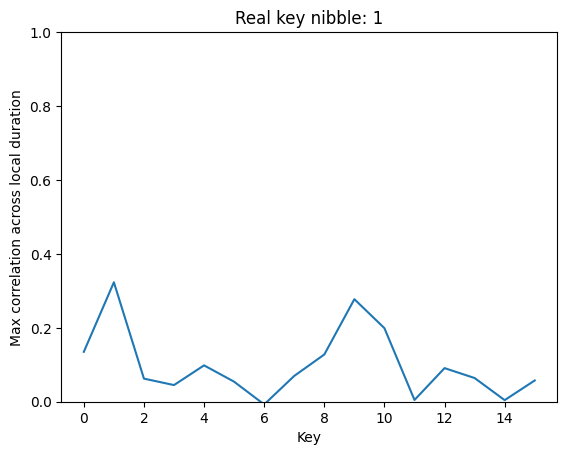

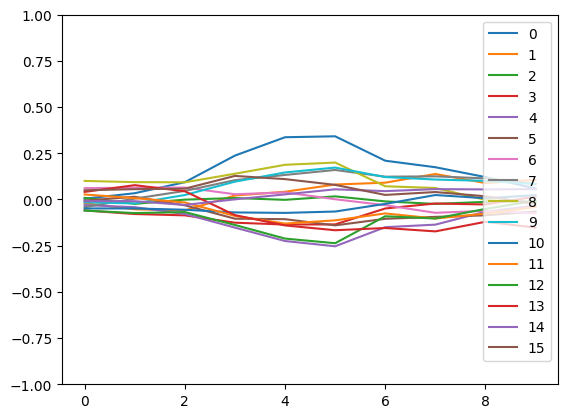

0[ 0.34187261  0.13795469  0.01682526  0.01558712 -0.03045175  0.01446058
  0.06444147  0.15967754  0.1998685   0.17263022  0.02399727  0.02706408
 -0.00640413  0.07745063  0.05598736  0.12745652]


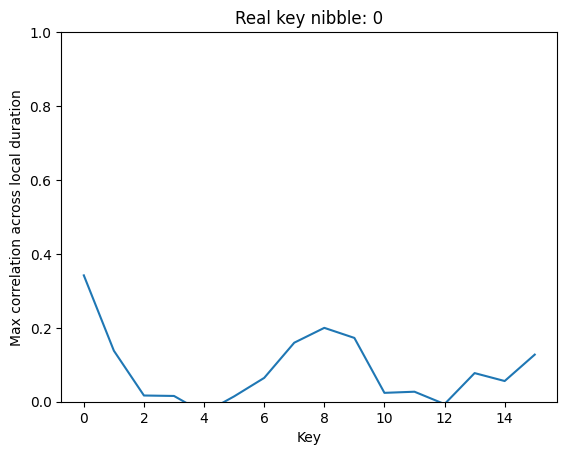

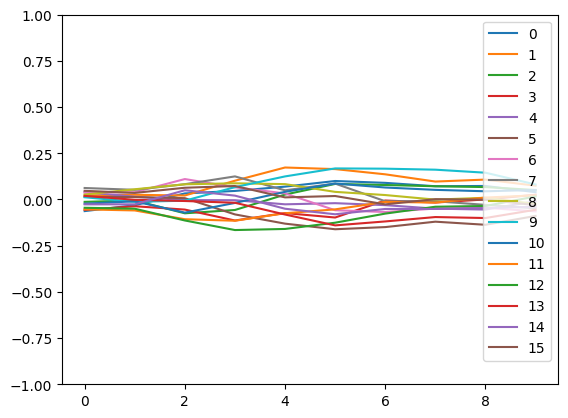

1[0.09999139 0.17298882 0.08412174 0.02565794 0.03984992 0.01405186
 0.11051819 0.1249245  0.0875109  0.16805071 0.08635499 0.0223023
 0.01650345 0.01946758 0.04991799 0.07291918]


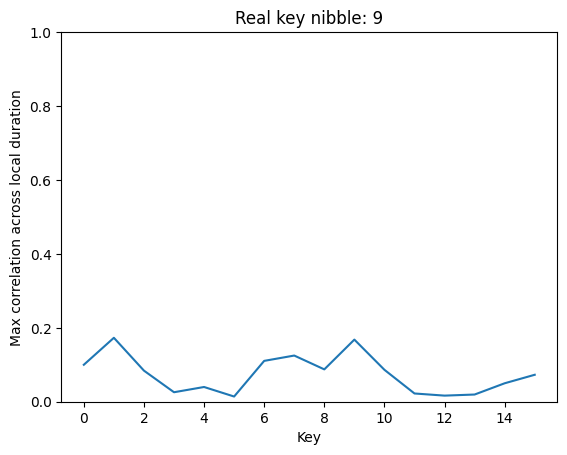

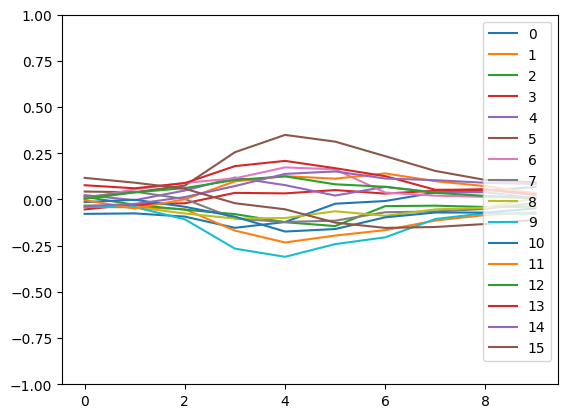

5[ 0.06748527 -0.03994168  0.0146453   0.05506529  0.1185321   0.34939003
  0.17362494  0.04236416  0.00675459 -0.04045709 -0.00151309  0.14110469
  0.12512522  0.2088401   0.15175071  0.11682449]


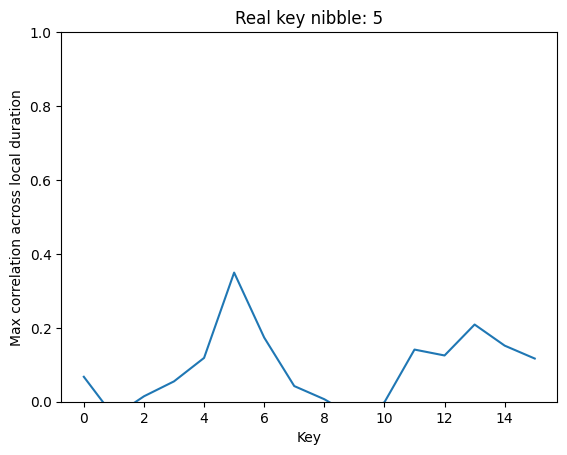

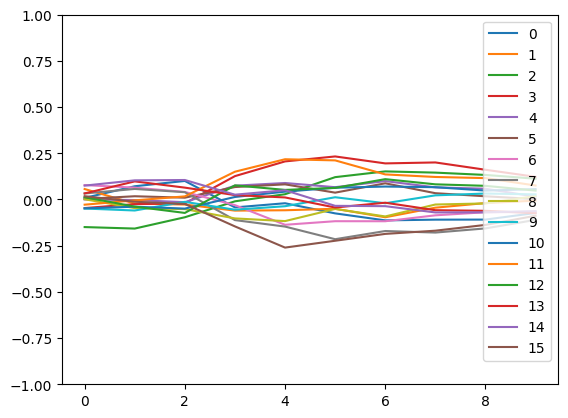

3[0.10021162 0.05658588 0.15195149 0.23284824 0.09942258 0.08748311
 0.07780804 0.05703804 0.01858264 0.0321474  0.06998806 0.21771619
 0.10998232 0.09791501 0.10538511 0.01776963]


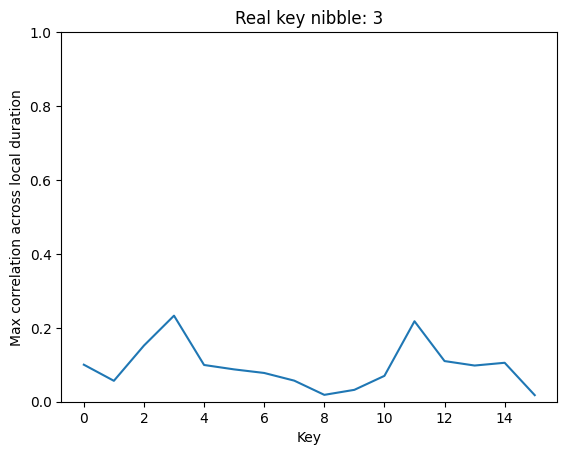

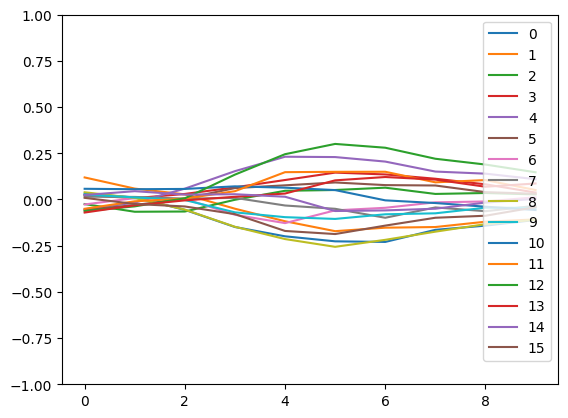

C[0.03096841 0.11923878 0.06383715 0.14538349 0.23130543 0.092039
 0.01210007 0.01512054 0.0389908  0.02676299 0.07104367 0.14994817
 0.30061188 0.1215516  0.04493713 0.0088553 ]


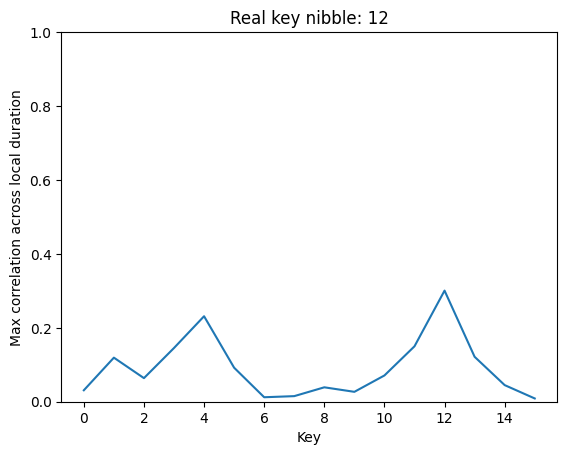

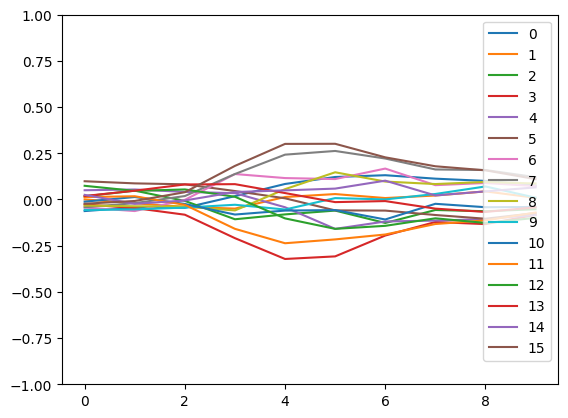

F[ 0.1312829   0.04375827  0.04775386 -0.02663268  0.05402486  0.09870474
  0.16722193  0.26252249  0.14717709  0.0704641   0.01330697  0.01746933
  0.07402994  0.08292479  0.10183194  0.30136149]


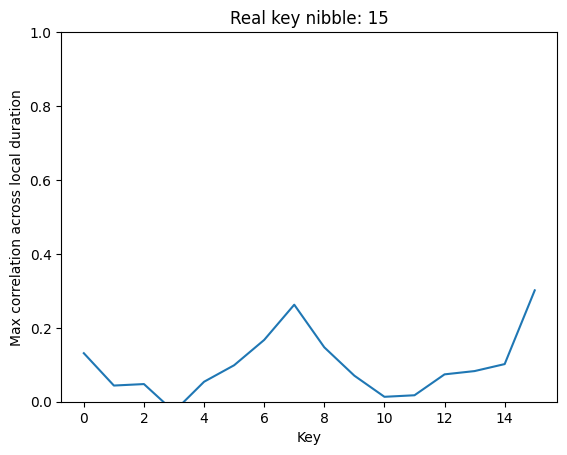

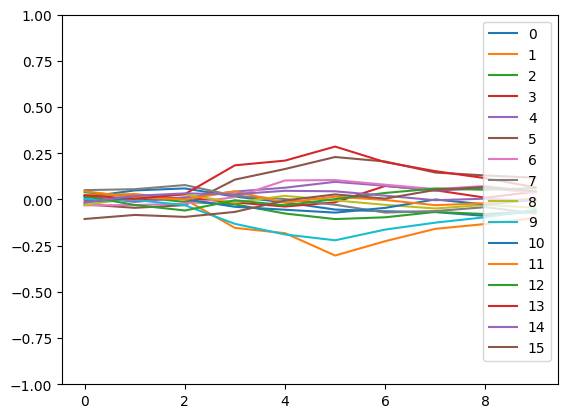

D[0.05975846 0.02958355 0.03903115 0.07314272 0.09546646 0.22974844
 0.10511044 0.07803413 0.02645511 0.00287861 0.00898312 0.04425679
 0.06119243 0.28630652 0.04691906 0.06789932]


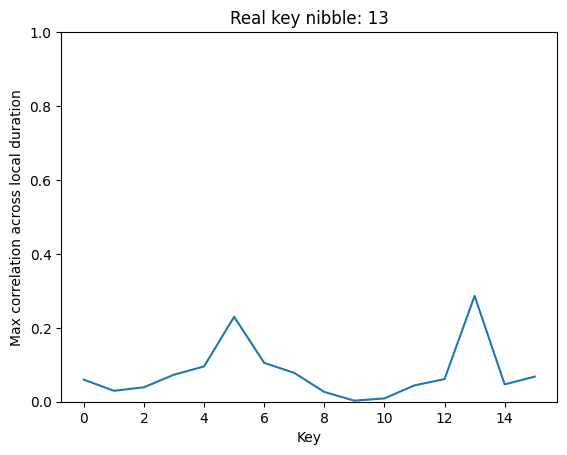

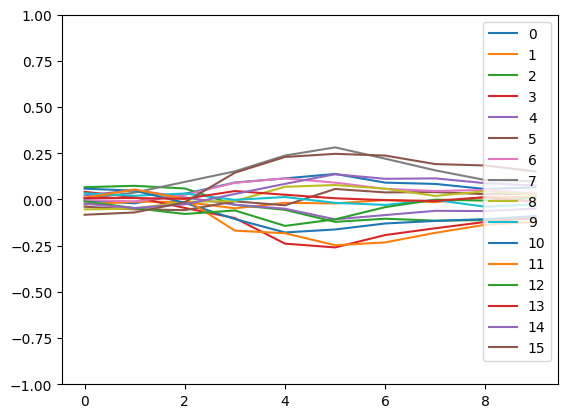

7[0.13818779 0.01434864 0.0739281  0.04123358 0.05064628 0.05684875
 0.11421426 0.28191775 0.07813585 0.03340119 0.05843441 0.05414233
 0.00729481 0.04563315 0.1365623  0.24696042]


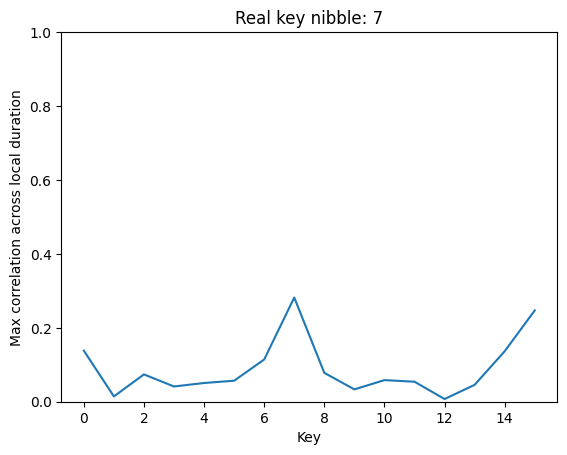

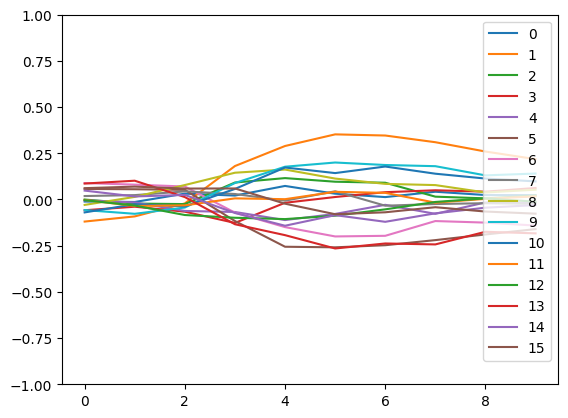

1[ 0.0732747   0.35233547  0.11568117  0.06215159 -0.00466169  0.05703093
  0.08881069  0.04431116  0.16190504  0.20002213  0.17835621  0.04147192
  0.00607965  0.10154782  0.04802907  0.06957988]


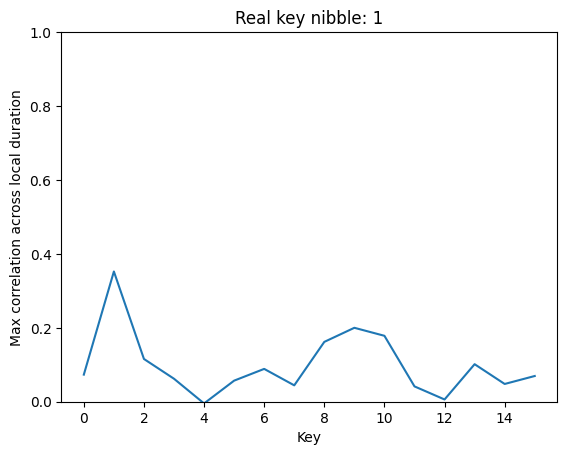

2

KeyboardInterrupt: 

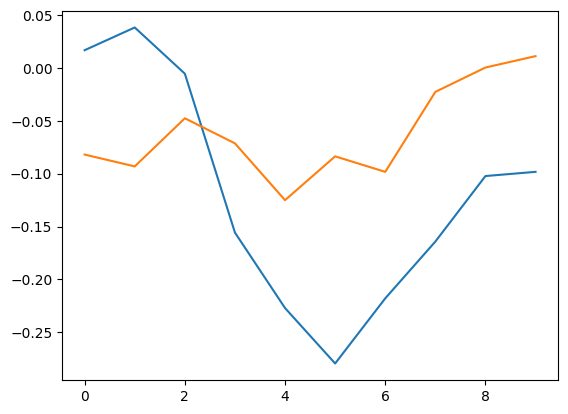

In [19]:
reconstructed_keys = np.zeros_like(real_keys)
for i in range(reconstructed_keys.shape[0]):
    print(f"Key {i}: ", end="")
    for j in range(reconstructed_keys.shape[1]):
        max_corrs = np.empty(16)

        for k in range(16):
            print(hex(k)[2:].upper(), end="")
            reconstructed_keys[i][j] = k

            indices, location_masks, hypotheses = indices_locations_and_hyps_to_use_for_key_nibble(reconstructed_keys[i], j, seeds[i], traces[i], correlation_locations)#np.array([[list(range(correlation_locations[i][j][5] - 25, correlation_locations[i][j][5] + 25)) for j in range(correlation_locations.shape[1])] for i in range(correlation_locations.shape[0])]))

            selected_seeds = seeds[i][indices]
            selected_traces = traces[i][location_masks].reshape((selected_seeds.shape[0], correlation_locations.shape[2]))

            corr = corr_coef(hypotheses, selected_traces)

            plt.plot(corr, label=str(k))

            #max_corrs[k] = np.max(np.abs(corr))
            max_corrs[k] = np.max(corr)
            print("\b", end="")

        plt.ylim([-1, 1])
        plt.legend()
        plt.show()

        best_k = np.argmax(max_corrs)
        reconstructed_keys[i][j] = best_k
        print(hex(best_k)[2:].upper(), end="")

        print(max_corrs)
        plt.plot(max_corrs)
        plt.xlabel("Key")
        plt.ylabel("Max correlation across local duration")
        plt.title(f"Real key nibble: {real_keys[i][j]}")
        plt.ylim([0, 1])
        plt.show()

    print()
    print(f"    vs {"".join([hex(k)[2:].upper() for k in real_keys[i]])}")
    print(f"{len(real_keys[i][real_keys[i] != reconstructed_keys[i]])} mistakes on {len(real_keys[i])} nibbles.")
    print()